# K-Means Clustering for a Netflix Movie Recommendation System

- Importing libraries

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msgno

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

- Loading the dataset

In [23]:
Netflix=pd.read_csv("Data.csv")
Netflix

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...
...,...,...,...,...,...,...,...,...,...,...,...,...
7782,s7783,Movie,Zozo,Josef Fares,"Imad Creidi, Antoinette Turk, Elias Gergi, Car...","Sweden, Czech Republic, United Kingdom, Denmar...","October 19, 2020",2005,TV-MA,99 min,"Dramas, International Movies",When Lebanon's Civil War deprives Zozo of his ...
7783,s7784,Movie,Zubaan,Mozez Singh,"Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...",India,"March 2, 2019",2015,TV-14,111 min,"Dramas, International Movies, Music & Musicals",A scrappy but poor boy worms his way into a ty...
7784,s7785,Movie,Zulu Man in Japan,NaN,Nasty C,NaN,"September 25, 2020",2019,TV-MA,44 min,"Documentaries, International Movies, Music & M...","In this documentary, South African rapper Nast..."
7785,s7786,TV Show,Zumbo's Just Desserts,NaN,"Adriano Zumbo, Rachel Khoo",Australia,"October 31, 2020",2019,TV-PG,1 Season,"International TV Shows, Reality TV",Dessert wizard Adriano Zumbo looks for the nex...


- Checking the data types

In [24]:
Netflix.dtypes

show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object

### Data Cleaning & Preparation

- Converting release year and date added into a date dtype

In [25]:
Netflix['release_year'] = pd.to_datetime(Netflix['release_year'])
Netflix['date_added'] = pd.to_datetime(Netflix['date_added'], format='mixed')

Netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       7787 non-null   object        
 1   type          7787 non-null   object        
 2   title         7787 non-null   object        
 3   director      5398 non-null   object        
 4   cast          7069 non-null   object        
 5   country       7280 non-null   object        
 6   date_added    7777 non-null   datetime64[ns]
 7   release_year  7787 non-null   datetime64[ns]
 8   rating        7780 non-null   object        
 9   duration      7787 non-null   object        
 10  listed_in     7787 non-null   object        
 11  description   7787 non-null   object        
dtypes: datetime64[ns](2), object(10)
memory usage: 730.2+ KB


- To check for duplicates

In [26]:
Netflix.duplicated().value_counts()

False    7787
Name: count, dtype: int64

- To get a visual understanding of the missingness : We use a matrix to understand the position of missingness

<Axes: >

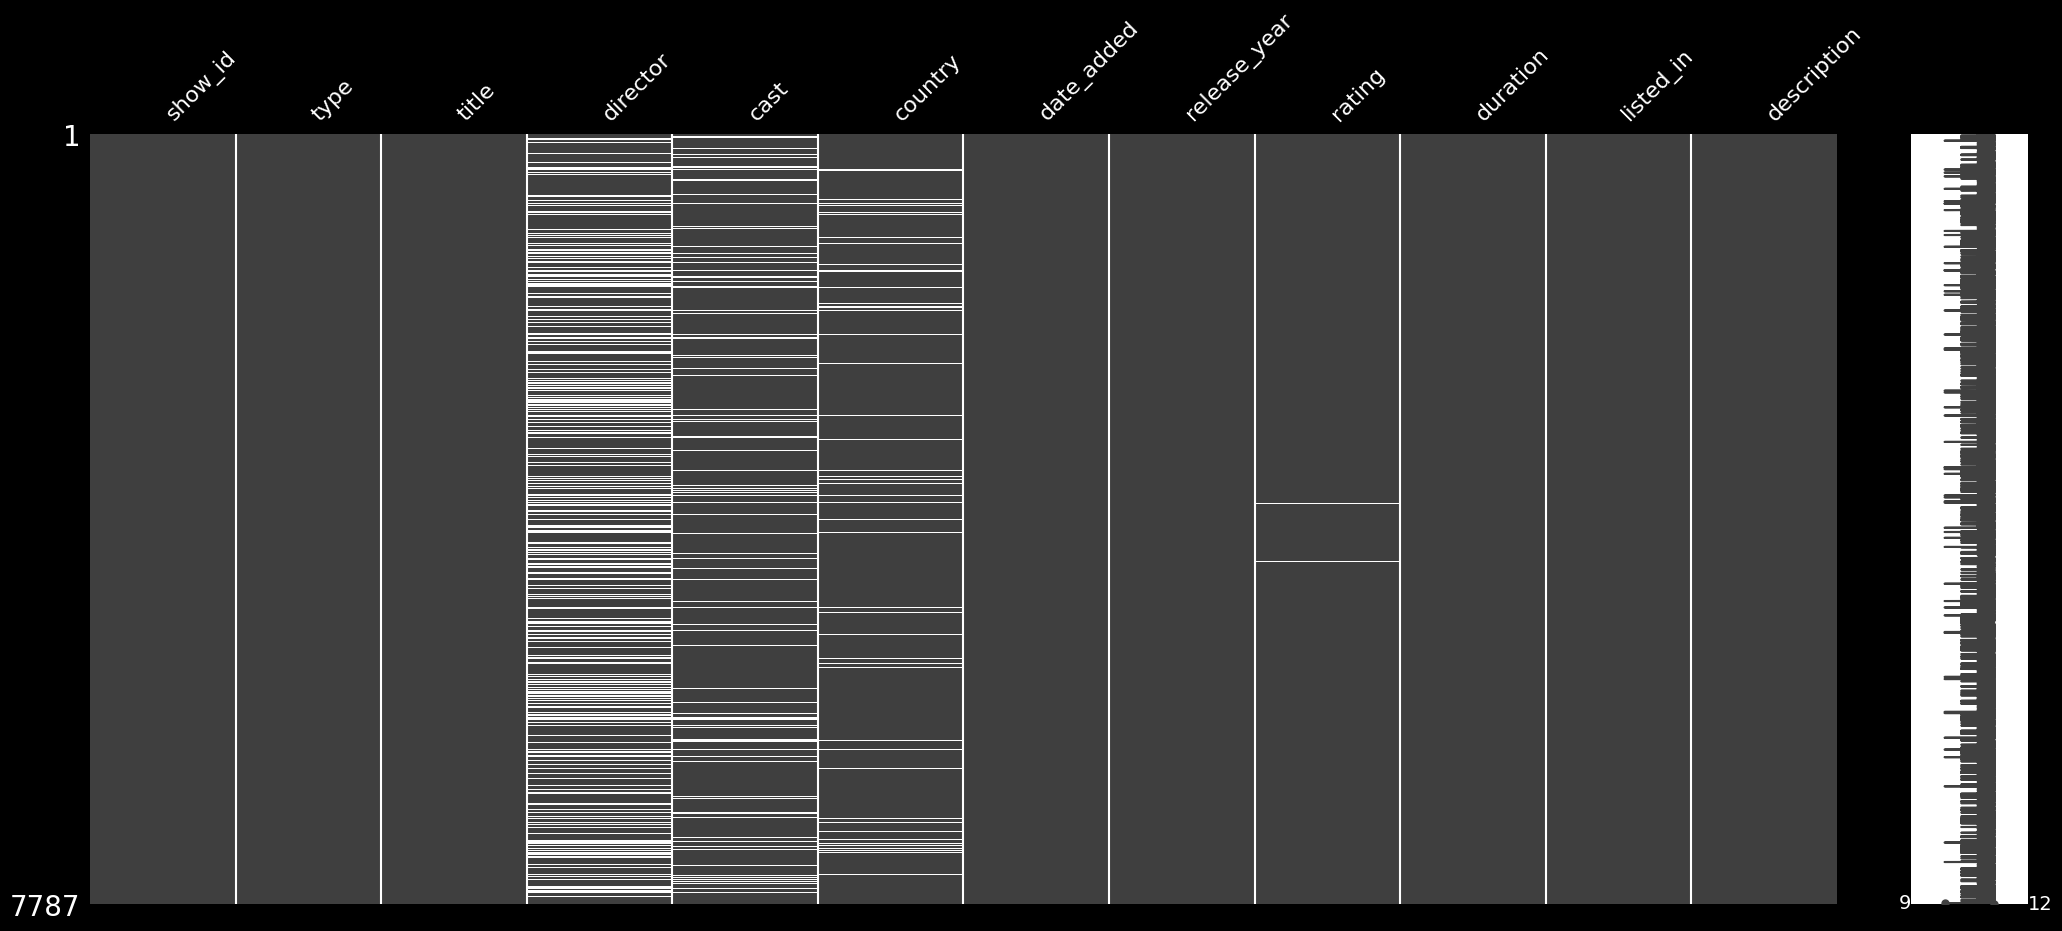

In [27]:
msgno.matrix(Netflix)

- Solutions to the missing bits:
   - Director, cast & country columns can be filled with 'unknown'.
   - The rating column can be filled with the modal rating
   - Missing date added rows will be dropped

<Axes: >

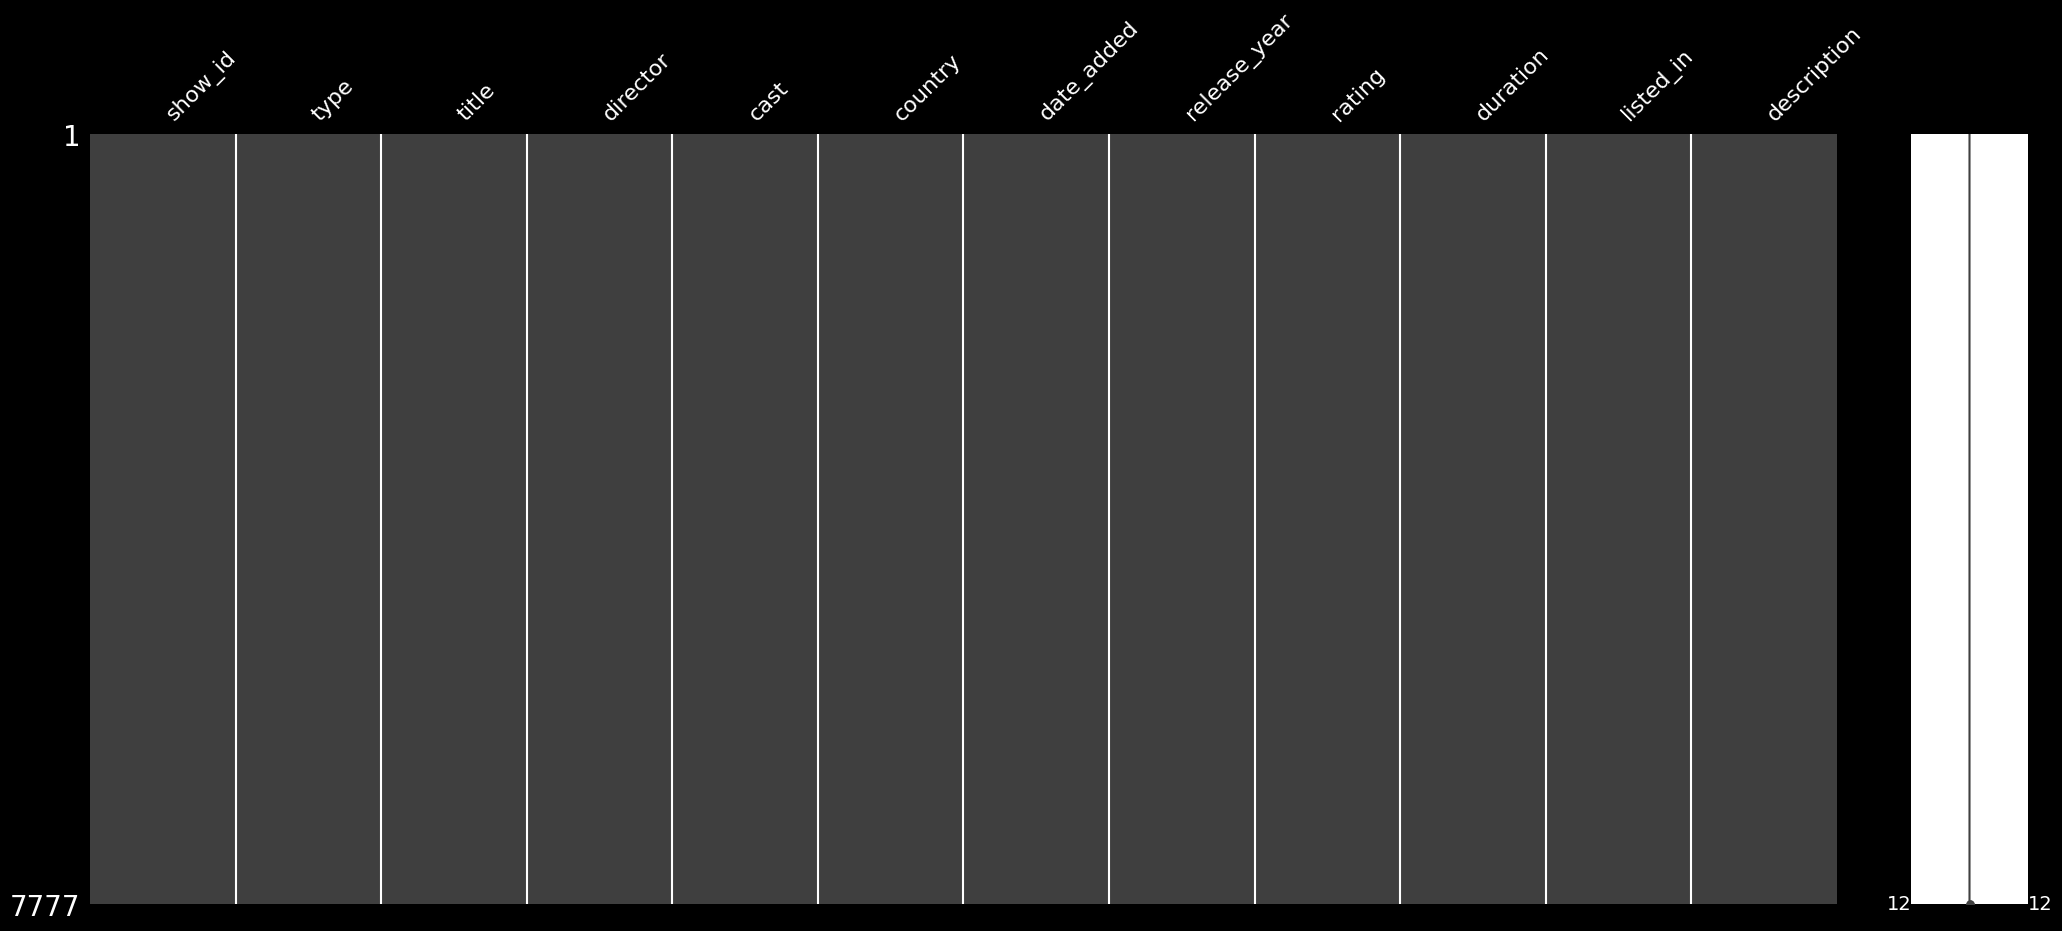

In [28]:
Netflix[['director','cast','country']] = Netflix[['director','cast','country']].fillna('Unknown')
Netflix['rating'] = Netflix['rating'].fillna(Netflix['rating'].mode()[0])
Netflix.dropna(axis=0, inplace = True)

msgno.matrix(Netflix)

- Categorizing the various ratings

In [29]:
rating_map = {'TV-MA':'Adults',
              'R':'Adults',
              'PG-13':'Teens',
              'TV-14':'Young Adults',
              'TV-PG':'Older Kids',
              'NR':'Adults',
              'TV-G':'Kids',
              'TV-Y':'Kids',
              'TV-Y7':'Older Kids',
              'PG':'Older Kids',
              'G':'Kids',
              'NC-17':'Adults',
              'TV-Y7-FV':'Older Kids',
              'UR':'Adults'}

Netflix['rating'].replace(rating_map, inplace = True)
Netflix['rating'].unique()

array(['Adults', 'Teens', 'Young Adults', 'Older Kids', 'Kids'],
      dtype=object)

### EDA

- Ratings 

<Axes: title={'center': 'Frequency of the various rating categories'}, xlabel='count', ylabel='rating'>

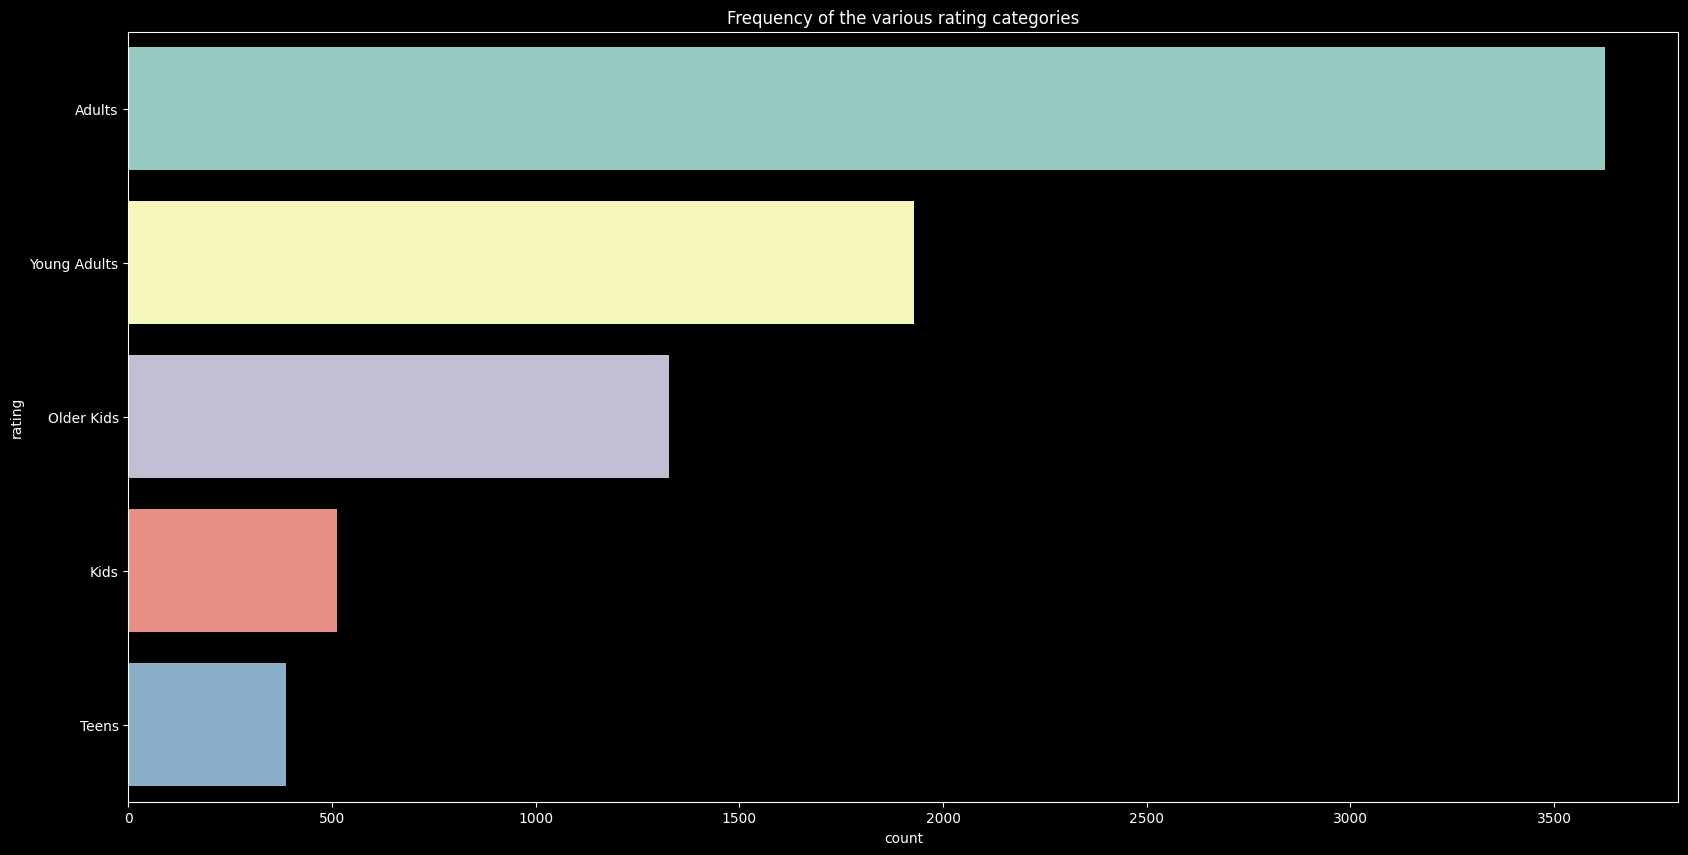

In [30]:
plt.figure(figsize=(20,10))
plt.title('Frequency of the various rating categories')

sns.countplot(data=Netflix, y='rating', order=Netflix['rating'].value_counts(ascending=False).index)

- Insight:
   - Adult rated films are the highest in the dataset followed by young adult rated films all the way to teen rated content 

- Number of Movies and TV Shows in the dataset

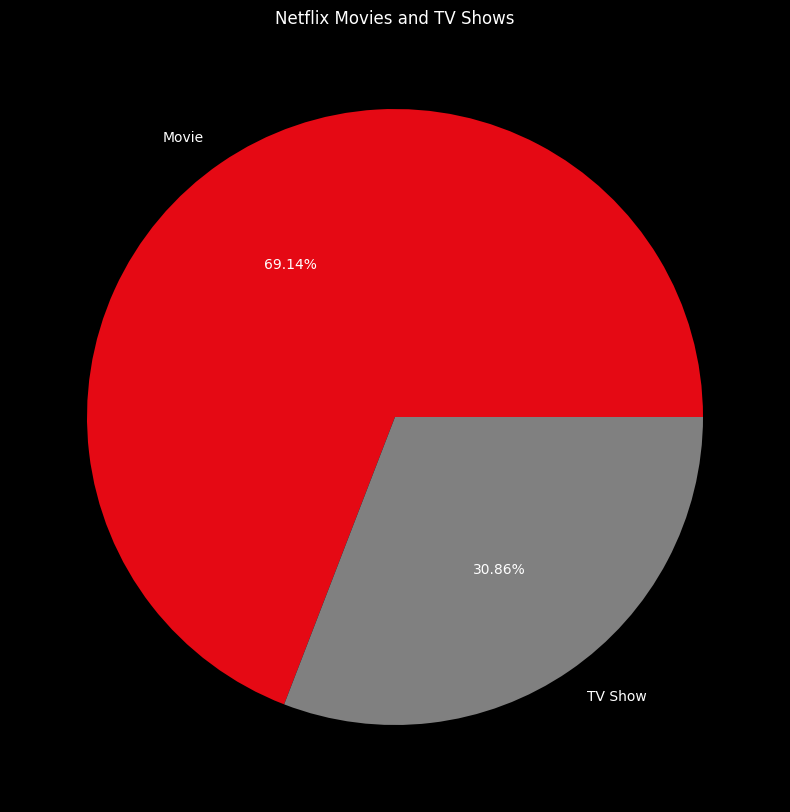

In [31]:
colors = ['#e50914', '#808080']

plt.figure(figsize=(20, 10))
plt.style.use('dark_background')
Netflix.type.value_counts().plot(kind='pie', autopct='%1.2f%%', colors=colors)
plt.ylabel('')
plt.title('Netflix Movies and TV Shows')

plt.show()